In [78]:
%reset -f

In [79]:
# ===== Block 0: Setup =====
import math
import numpy as np
import torch
import torch.nn as nn
import torch.nn.functional as F

# For resampling in a simple, dependency-light way
from scipy.signal import resample_poly

# Make results reproducible
torch.manual_seed(0)
np.random.seed(0)

def print_tensor(name, x):
    """
    Utility to print a tensor's shape and dtype.
    """
    print(f"{name}: shape={tuple(x.shape)}, dtype={x.dtype}")


In [80]:
# ===== Block 1: Step 1 - Generate toy PSG-like signals =====

duration_sec = 120  # 2 minutes toy recording (keep small for experimentation)

# Different sampling rates (Hz = samples per second)
fs = {
    "EEG": 256,
    "ECG": 250,
    "RESP": 25,
    "SPO2": 1
}

def make_time(fs_hz, duration_sec):
    """
    Create a time vector t with shape [T] in seconds.
    """
    T = int(fs_hz * duration_sec)
    t = np.arange(T) / fs_hz
    return t

def add_gaussian_noise(x, std=0.1):
    return x + np.random.normal(0.0, std, size=x.shape)

def simulate_eeg(t):
    """
    Fake EEG: mix of slow wave (~1 Hz) + "alpha" (~10 Hz) + noise.
    """
    slow = 0.8 * np.sin(2 * np.pi * 1.0 * t)
    alpha = 0.3 * np.sin(2 * np.pi * 10.0 * t)
    x = slow + alpha
    x = add_gaussian_noise(x, std=0.2)
    return x

def simulate_ecg(t):
    """
    Fake ECG-like signal: simple periodic spikes-ish waveform using sin + nonlinearity.
    (This is NOT physiologically accurate; it's just a toy waveform.)
    """
    base_hr_hz = 1.2  # ~72 bpm
    wave = np.sin(2 * np.pi * base_hr_hz * t)
    spikes = np.maximum(wave, 0) ** 6  # makes sharp peaks
    x = 0.6 * spikes
    x = add_gaussian_noise(x, std=0.05)
    return x

def simulate_resp(t):
    """
    Fake respiration: ~0.25 Hz (15 breaths/min) sinusoid + noise.
    Add a couple "apnea-like" events: reduce amplitude in certain windows.
    """
    resp = np.sin(2 * np.pi * 0.25 * t)
    resp = add_gaussian_noise(resp, std=0.05)

    # Apnea-like dips: reduce amplitude between 40-55 sec and 90-100 sec
    mask1 = (t >= 40) & (t <= 55)
    mask2 = (t >= 90) & (t <= 100)
    resp[mask1] *= 0.2
    resp[mask2] *= 0.3
    return resp

def simulate_spo2(t):
    """
    Fake SpO2: around 97% with small noise and dips during apnea-like windows.
    Very low sampling rate (1 Hz) like a wearable.
    """
    spo2 = 97 + 0.3 * np.sin(2 * np.pi * (1/60) * t)  # slow drift
    spo2 = add_gaussian_noise(spo2, std=0.2)

    # Dips aligned with apnea windows
    mask1 = (t >= 40) & (t <= 55)
    mask2 = (t >= 90) & (t <= 100)
    spo2[mask1] -= 2.0
    spo2[mask2] -= 1.5
    return spo2

# Create each modality at its own sampling rate
signals = {}

t_eeg = make_time(fs["EEG"], duration_sec)
signals["EEG"] = simulate_eeg(t_eeg)

t_ecg = make_time(fs["ECG"], duration_sec)
signals["ECG"] = simulate_ecg(t_ecg)

t_resp = make_time(fs["RESP"], duration_sec)
signals["RESP"] = simulate_resp(t_resp)

t_spo2 = make_time(fs["SPO2"], duration_sec)
signals["SPO2"] = simulate_spo2(t_spo2)

# Convert to torch tensors: shape [T] for each modality
for k in signals:
    signals[k] = torch.tensor(signals[k], dtype=torch.float32)

print("Raw signals at different sampling rates:")
for k in signals:
    print(f"{k}: fs={fs[k]} Hz, length={signals[k].shape[0]} samples")


Raw signals at different sampling rates:
EEG: fs=256 Hz, length=30720 samples
ECG: fs=250 Hz, length=30000 samples
RESP: fs=25 Hz, length=3000 samples
SPO2: fs=1 Hz, length=120 samples


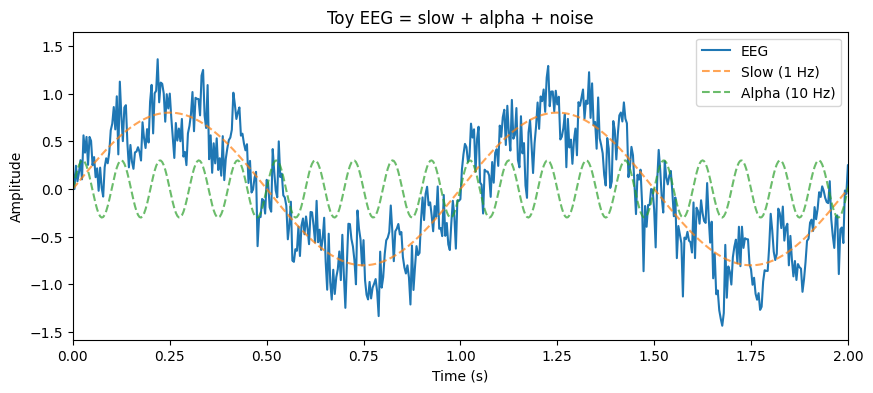

In [76]:
# #EEG toy signal Visualization code (may mess up with block2)
# import numpy as np
# import matplotlib.pyplot as plt

# fs = 256          # sampling rate
# duration = 5      # seconds
# t = np.arange(fs * duration) / fs

# slow = 0.8 * np.sin(2 * np.pi * 1 * t)
# alpha = 0.3 * np.sin(2 * np.pi * 10 * t)
# noise = np.random.normal(0, 0.2, size=t.shape)

# eeg = slow + alpha + noise

# plt.figure(figsize=(10,4))
# plt.plot(t, eeg, label="EEG")
# plt.plot(t, slow, '--', label="Slow (1 Hz)", alpha=0.7)
# plt.plot(t, alpha, '--', label="Alpha (10 Hz)", alpha=0.7)
# plt.xlim(0, 2)
# plt.xlabel("Time (s)")
# plt.ylabel("Amplitude")
# plt.title("Toy EEG = slow + alpha + noise")
# plt.legend()
# plt.show()


In [82]:
# ===== Block 2: Step 2 - Resample to common rate + chunk into 5s windows =====

target_fs = 128  # common sampling rate (Hz)
window_sec = 5   # each token is 5 seconds
window_len = target_fs * window_sec  # samples per window at target_fs

def resample_to_target(x, fs_in, fs_out):
    """
    Resample 1D signal x from fs_in to fs_out using polyphase resampling.

    Why this function?
    - Different channels come at different rates.
    - We want them aligned on the same time grid.
    """
    x_np = x.numpy()

    # resample_poly needs integer up/down factors.
    # We'll approximate ratio fs_out/fs_in using fractions:
    # Example: 128/256 = 1/2 => up=1, down=2
    # Example: 128/250 = 64/125 => up=64, down=125
    from fractions import Fraction
    frac = Fraction(fs_out, fs_in).limit_denominator(1000)
    up, down = frac.numerator, frac.denominator

    y_np = resample_poly(x_np, up=up, down=down)
    return torch.tensor(y_np, dtype=torch.float32)

# Resample all modalities
signals_rs = {}
for k, x in signals.items():
    signals_rs[k] = resample_to_target(x, fs_in=fs[k], fs_out=target_fs)

print("Resampled signals (now all at target_fs=128 Hz):")
for k in signals_rs:
    print(f"{k}: length={signals_rs[k].shape[0]} samples")

# Make sure all signals have exactly the same length in samples
# (Real data may have slight mismatches; here we just crop to min length.)
min_len = min([v.shape[0] for v in signals_rs.values()])
for k in signals_rs:
    signals_rs[k] = signals_rs[k][:min_len]

print("\nAfter cropping to same length:")
for k in signals_rs:
    print(f"{k}: length={signals_rs[k].shape[0]} samples")

# Stack modalities into one tensor of shape [C, T]
# C = number of channels/modalities, T = time samples
channel_names = list(signals_rs.keys())
X = torch.stack([signals_rs[name] for name in channel_names], dim=0)
print_tensor("X (stacked modalities)", X)
print("Channel order:", channel_names)

# ---- Chunk into non-overlapping 5-second windows ----
C, T = X.shape

num_windows = T // window_len  # floor division
T_used = num_windows * window_len

X_used = X[:, :T_used]  # crop to multiple of window_len

# reshape into [C, num_windows, window_len] then transpose to [num_windows, C, window_len]
X_windows = X_used.view(C, num_windows, window_len).permute(1, 0, 2).contiguous()

print_tensor("X_windows (tokens)", X_windows)
print(f"Each token = {window_sec}s = {window_len} samples. num_windows={num_windows}")


Resampled signals (now all at target_fs=128 Hz):
EEG: length=15360 samples
ECG: length=15360 samples
RESP: length=15360 samples
SPO2: length=15360 samples

After cropping to same length:
EEG: length=15360 samples
ECG: length=15360 samples
RESP: length=15360 samples
SPO2: length=15360 samples
X (stacked modalities): shape=(4, 15360), dtype=torch.float32
Channel order: ['EEG', 'ECG', 'RESP', 'SPO2']
X_windows (tokens): shape=(24, 4, 640), dtype=torch.float32
Each token = 5s = 640 samples. num_windows=24


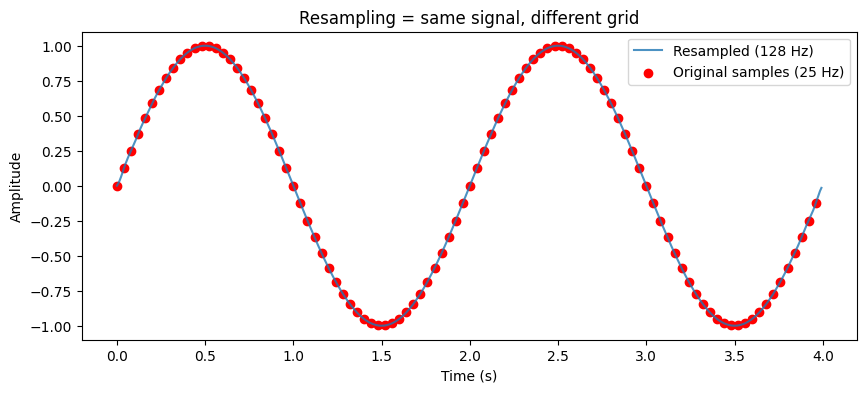

In [70]:
# #Resampling Visualization
# import numpy as np
# import matplotlib.pyplot as plt
# from scipy.signal import resample_poly

# # Original signal
# fs_in = 25
# fs_out = 128
# duration = 4

# t_in = np.arange(fs_in * duration) / fs_in
# x_in = np.sin(2 * np.pi * 0.5 * t_in)

# # Resample
# x_out = resample_poly(x_in, up=fs_out, down=fs_in)
# t_out = np.arange(len(x_out)) / fs_out

# plt.figure(figsize=(10,4))
# plt.plot(t_out, x_out, label="Resampled (128 Hz)", alpha=0.8)
# plt.scatter(t_in, x_in, color="red", label="Original samples (25 Hz)")
# plt.xlabel("Time (s)")
# plt.ylabel("Amplitude")
# plt.title("Resampling = same signal, different grid")
# plt.legend()
# plt.show()


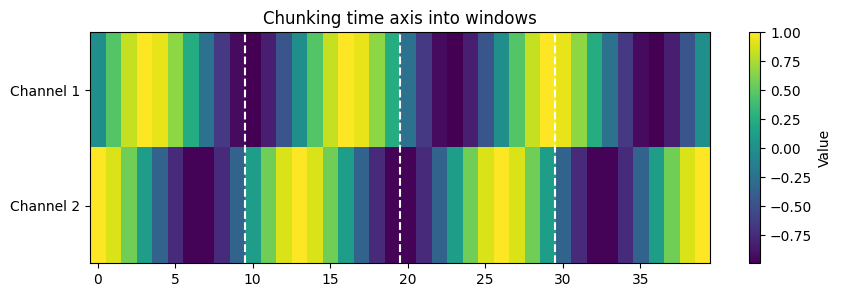

In [53]:
# #Chunking Visualization
# # Fake stacked signal: 2 channels, 40 time points
# X_Vis = np.vstack([
#     np.sin(np.linspace(0, 6*np.pi, 40)),
#     np.cos(np.linspace(0, 6*np.pi, 40))
# ])

# window_len = 10
# num_windows = X_Vis.shape[1] // window_len

# plt.figure(figsize=(10,3))
# plt.imshow(X_Vis, aspect="auto", cmap="viridis")
# for w in range(1, num_windows):
#     plt.axvline(w * window_len - 0.5, color="white", linestyle="--")
# plt.yticks([0,1], ["Channel 1", "Channel 2"])
# plt.title("Chunking time axis into windows")
# plt.colorbar(label="Value")
# plt.show()


In [91]:
# ===== Block 3: Step 3 - Local feature extraction (Conv1D encoder) =====

class ConvTokenEncoder(nn.Module):
    """
    Takes a batch of tokens shaped [B, C, L]
    where:
      B = number of windows (tokens)
      C = channels/modalities
      L = samples per token (window_len)

    Outputs token embeddings [B, D] where D is feature_dim.
    """
    def __init__(self, in_channels, feature_dim=64):
        super().__init__()

        # Conv1d expects input [B, C, L]
        # We'll build a small CNN.
        self.conv1 = nn.Conv1d(in_channels, 32, kernel_size=9, stride=1, padding=4)
        self.conv2 = nn.Conv1d(32, 64, kernel_size=9, stride=2, padding=4)  # stride=2 halves time length
        self.conv3 = nn.Conv1d(64, feature_dim, kernel_size=9, stride=2, padding=4)  # halves again

        # Normalization helps training (even in toy examples)
        self.bn1 = nn.BatchNorm1d(32)
        self.bn2 = nn.BatchNorm1d(64)
        self.bn3 = nn.BatchNorm1d(feature_dim)

    def forward(self, x):
        # x: [B, C, L]
        x = self.conv1(x)
        x = self.bn1(x)
        x = F.relu(x)

        x = self.conv2(x)
        x = self.bn2(x)
        x = F.relu(x)

        x = self.conv3(x)
        x = self.bn3(x)
        x = F.relu(x)

        # Now x is [B, feature_dim, L_reduced]
        # Global average pool over time => [B, feature_dim]
        x = x.mean(dim=-1)
        return x

# Create model and run forward pass
B, C, L = X_windows.shape
model = ConvTokenEncoder(in_channels=C, feature_dim=64)

token_embeddings = model(X_windows)  # [B, 64]
print_tensor("token_embeddings", token_embeddings)

# Show a few token embeddings values to see it's working
print("\nFirst token embedding (first 10 dims):")
print(token_embeddings[0, :10].detach())

token_embeddings: shape=(24, 64), dtype=torch.float32

First token embedding (first 10 dims):
tensor([0.2128, 0.2579, 0.1672, 0.1125, 0.2012, 0.1393, 0.2295, 0.1933, 0.2261,
        0.1778])


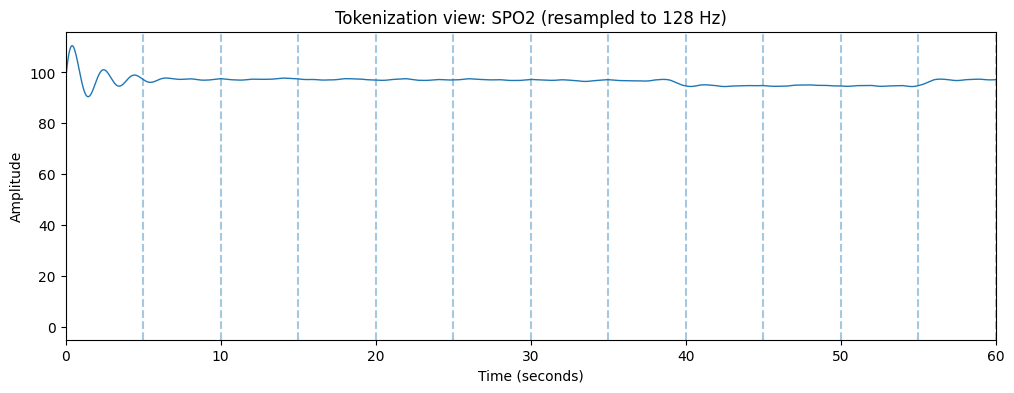

T=15360 samples, window_len=640 samples (5s), num_windows=24


In [92]:
import matplotlib.pyplot as plt
# Pick a channel to visualize (change this)
channel_to_plot = "SPO2"  # try "EEG", "ECG", "RESP", "SPO2"
ch_idx = channel_names.index(channel_to_plot)

# Use the resampled stacked matrix X: shape [C, T]
x = X[ch_idx].detach().cpu().numpy()
T = x.shape[0]
t = np.arange(T) / target_fs

plt.figure(figsize=(12, 4))
plt.plot(t, x, linewidth=1)
plt.title(f"Tokenization view: {channel_to_plot} (resampled to {target_fs} Hz)")
plt.xlabel("Time (seconds)")
plt.ylabel("Amplitude")

# Draw vertical lines at window boundaries
num_windows = T // window_len
for w in range(1, num_windows):
    plt.axvline(w * window_sec, linestyle="--", alpha=0.4)

plt.xlim(0, min(60, t[-1]))  # show first 60s for readability
plt.show()

print(f"T={T} samples, window_len={window_len} samples ({window_sec}s), num_windows={num_windows}")

In [93]:
# ===== Block 4: Optional - experiments =====

# Try changing window_sec above (e.g., 2s or 10s), re-run blocks 2-3,
# and observe how X_windows shape changes and whether embeddings still work.

print("Current shapes recap:")
print_tensor("X", X)
print_tensor("X_windows", X_windows)
print_tensor("token_embeddings", token_embeddings)

# Example: number of tokens equals time / window size
print(f"Total duration used: {T_used/target_fs:.1f} seconds")
print(f"Tokens: {num_windows} tokens of {window_sec} seconds each")

Current shapes recap:
X: shape=(4, 15360), dtype=torch.float32
X_windows: shape=(24, 4, 640), dtype=torch.float32
token_embeddings: shape=(24, 64), dtype=torch.float32
Total duration used: 120.0 seconds
Tokens: 24 tokens of 5 seconds each
